In [1]:
import fitbit
import gather_keys_oauth2 as Oauth2
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
import matplotlib.dates as mdates
import requests
import base64

In [2]:
CLIENT_ID = ''
CLIENT_SECRET = ''

server = Oauth2.OAuth2Server(CLIENT_ID, CLIENT_SECRET)
server.browser_authorize()

[19/May/2023:11:57:00] ENGINE Listening for SIGTERM.
[19/May/2023:11:57:00] ENGINE Listening for SIGHUP.
[19/May/2023:11:57:00] ENGINE Listening for SIGUSR1.
[19/May/2023:11:57:00] ENGINE Bus STARTING
CherryPy Checker:
The Application mounted at '' has an empty config.

[19/May/2023:11:57:00] ENGINE Started monitor thread 'Autoreloader'.
[19/May/2023:11:57:00] ENGINE Serving on http://127.0.0.1:8080
[19/May/2023:11:57:00] ENGINE Bus STARTED


127.0.0.1 - - [19/May/2023:11:58:04] "GET /?code=5e832038d591a6342543c1fe27c7787837ee154d&state=d5WyLLvFVbBp6msbEe5f2EgPTzf6P3 HTTP/1.1" 200 122 "" "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:109.0) Gecko/20100101 Firefox/113.0"


[19/May/2023:11:58:05] ENGINE Bus STOPPING
[19/May/2023:11:58:06] ENGINE HTTP Server cherrypy._cpwsgi_server.CPWSGIServer(('127.0.0.1', 8080)) shut down
[19/May/2023:11:58:06] ENGINE Stopped thread 'Autoreloader'.
[19/May/2023:11:58:06] ENGINE Bus STOPPED
[19/May/2023:11:58:06] ENGINE Bus EXITING
[19/May/2023:11:58:06] ENGINE Bus EXITED
[19/May/2023:11:58:06] ENGINE Waiting for child threads to terminate...


In [3]:
ACCESS_TOKEN = str(server.fitbit.client.session.token['access_token'])
REFRESH_TOKEN = str(server.fitbit.client.session.token['refresh_token'])
auth2_client = fitbit.Fitbit(CLIENT_ID, CLIENT_SECRET, oauth2=True, access_token=ACCESS_TOKEN, refresh_token=REFRESH_TOKEN)

Request succesful!


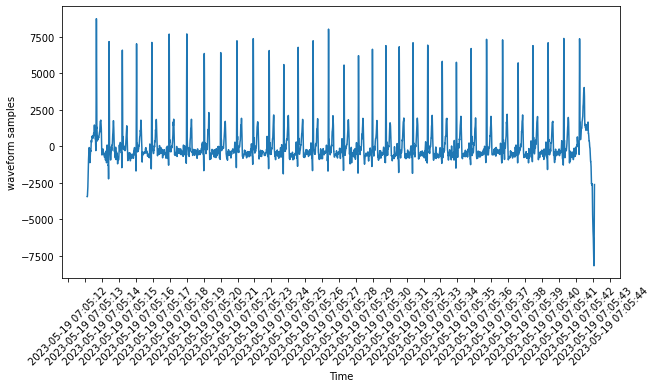

In [6]:
# to get the exchanged ACCESS_TOKEN see https://dev.fitbit.com/build/reference/web-api/troubleshooting-guide/oauth2-tutorial/
# the Authorization Code and the State are encoded in the Authorization URL
# the ACCESS_TOKEN expiries in 8 hours

url = 'https://api.fitbit.com/1/user/-/ecg/list.json'
ACCESS_TOKEN = ''
headers = {'Authorization': 'Bearer ' + ACCESS_TOKEN}
params = {'afterDate': '2023-05-19', 'sort': 'asc', 'limit': 1, 'offset': 0}

response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    # Request successful
    ecg_data = response.json()
    print('Request succesful!')
else:
    # Request failed
    print('Request failed with status code:', response.status_code)
    print('Error type:', type(response.raise_for_status()))
    

waveformSamples = ecg_data['ecgReadings'][0]['waveformSamples']    

startTime = ecg_data['ecgReadings'][0]['startTime']
format = '%Y-%m-%dT%H:%M:%S.%f'
startTime = datetime.strptime(startTime, format)
endTime = startTime + timedelta(seconds=30)
time_diff = endTime - startTime
time_points = [startTime + i * time_diff / (len(waveformSamples)-1) for i in range(len(waveformSamples))]

df = pd.DataFrame({
    'time': time_points,
    'waveformSamples': waveformSamples
})

time_values = df['time']
data_values = df['waveformSamples']
plt.plot(time_values, data_values)
plt.xlabel('Time')
plt.ylabel('waveform samples')
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.SecondLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
plt.xticks(rotation=45)
plt.show()

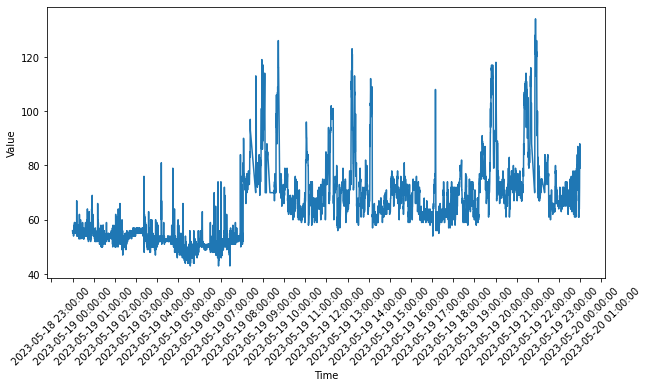

In [7]:
# Heart rate

oneDate = datetime(year=2023,month=5,day=12)
oneDayData = auth2_client.intraday_time_series('activities/heart', oneDate, detail_level='1sec')
df = pd.DataFrame(oneDayData['activities-heart-intraday']['dataset'])
df['time'] = pd.to_datetime(df['time'])
time_values = df['time']
data_values = df['value']
plt.plot(time_values, data_values)
plt.xlabel('Time')
plt.ylabel('Value')
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
plt.xticks(rotation=45)
plt.show()